# Acknowledgement: 

This work was originally from the Regression part of the paper "Martingale posterior distributions" by Edwin Fong et. al. 

Instead of setting up a Jax environment locally, this work shows how to replicate the result using Google Colab, as well as replacing ***jax.ops.index_update*** with ***jax.numpy.ndarray.at*** due to the version difference of Jax on Google Colab.

Paper Link: https://arxiv.org/abs/2103.15671

Paper Github Link: https://github.com/edfong/MP


In [3]:
import pandas as pd
import jax.numpy as jnp
from jax import vmap, grad
from jax.random import permutation,PRNGKey,split
import numpy as np
import matplotlib.pyplot as plt
import time
from jax import custom_jvp,jit
from jax.scipy.special import ndtri
from jax.scipy.stats import norm,t
from scipy.optimize import minimize,root
from collections import namedtuple

##Read dataset

In [4]:
print('Dataset: LIDAR')
DATA_URI = 'http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat'

df = pd.read_csv('lidar.dat',delim_whitespace = True)
y = df['logratio'].values
x = df['range'].values.reshape(-1,1)

Dataset: LIDAR


In [5]:
df.head()

,range,logratio
0,390,-0.050356
1,391,-0.060097
2,393,-0.041901
3,394,-0.050985
4,396,-0.059913


In [6]:
y =(y-np.mean(y))/jnp.std(y)
x = (x - np.mean(x,axis = 0))/np.std(x,axis = 0)

In [7]:
np.savetxt("lidar_x.csv",x,delimiter = ',')
np.savetxt("lidar_y.csv",y,delimiter = ',')

Text(0.5, 1.0, 'Standardized LIDAR Dataset')

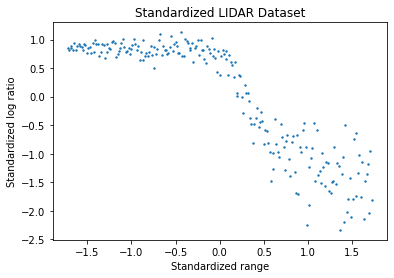

In [8]:
plt.scatter(x,y, s= 2)
plt.xlabel('Standardized range')
plt.ylabel('Standardized log ratio')
plt.title('Standardized LIDAR Dataset')

## init

In [9]:
y_plot = np.linspace(-3.0,2.0,num = 200)
n_plot_y = np.shape(y_plot)[0]
dy = y_plot[1] - y_plot[0]

x_plot = np.linspace(jnp.min(x),jnp.max(x),num = 40)
n_plot_x = np.shape(x_plot)[0]
dx = x_plot[1] - x_plot[0]

n = jnp.shape(y)[0]
n_plot_marg = np.array([jnp.shape(x_plot)[0],jnp.shape(y_plot)[0]])

xlim = (-2.0,2.0)
ylim = (-2.5,1.7)

z_plot_grid = np.meshgrid(x_plot,y_plot)
x_plot_ravel = z_plot_grid[0].ravel().reshape(-1,1)
y_plot_ravel = z_plot_grid[1].ravel()


## Joint Method

### Helper Functions for $\texttt{fit_copula_jregression}$

In [10]:
@custom_jvp 
def ndtri_(u):
    return ndtri(u)
@ndtri_.defjvp
def f_jvp(primals, tangents):
    u, = primals
    u_dot, = tangents
    primal_out = ndtri_(u)
    tangent_out = (1/norm.pdf(primal_out))*u_dot
    return primal_out, tangent_out
ndtri_ = jit(ndtri_)

#Custom derivatives for logPhi to speed up autograd
@custom_jvp
def norm_logcdf(z):
    return norm.logcdf(z)
@norm_logcdf.defjvp
def f_jvp(primals, tangents):
    z, = primals
    z_dot, = tangents
    primal_out = norm_logcdf(z)
    tangent_out = jnp.exp(norm.logpdf(z)-primal_out)*z_dot
    return primal_out, tangent_out
norm_logcdf = jit(norm_logcdf)


@jit
def norm_copula_logdistribution_logdensity(u,v,rho):
    #clip to prevent 0s and 1s in CDF, needed for numerical stability in high d.
    eps = 1e-6
    u = jnp.clip(u,eps,1-eps) 
    v = jnp.clip(v,eps,1-eps)
    
    #for reverse mode
    pu = ndtri_(u)
    pv = ndtri_(v)
    z = (pu - rho*pv)/jnp.sqrt(1- rho**2)

    logcop_dist = norm_logcdf(z)
    logcop_dist = jnp.clip(logcop_dist,jnp.log(eps),jnp.log(1-eps))
    logcop_dens = -0.5*jnp.log(1-rho**2) + (0.5/(1-rho**2))*(-(rho**2)*(pu**2 + pv**2)+ 2*rho*pu*pv)

    return logcop_dist,logcop_dens
### ###

In [11]:
def update_copula_single(logcdf_conditionals,logpdf_joints,u,v,logalpha,rho): 
    d = jnp.shape(logpdf_joints)[0]

    logcop_distribution,logcop_dens = norm_copula_logdistribution_logdensity(u,v,rho)

    #Calculate product copulas
    logcop_dens_prod = jnp.cumsum(logcop_dens)

    #staggered 1 step to calculate conditional cdfs
    logcop_dens_prod_staggered = jnp.concatenate((jnp.zeros(1),logcop_dens_prod[0:d-1]))

    log1alpha = jnp.log1p(-jnp.exp(logalpha))

    logcdf_conditionals = jnp.logaddexp((log1alpha + logcdf_conditionals),(logalpha + logcop_dens_prod_staggered + logcop_distribution))\
                           -jnp.logaddexp(log1alpha,(logalpha+logcop_dens_prod_staggered))

    logpdf_joints = jnp.logaddexp(log1alpha, (logalpha+logcop_dens_prod))+logpdf_joints     

    return logcdf_conditionals,logpdf_joints

update_copula = jit(vmap(update_copula_single,(0,0,0,None,None,None))) 



In [12]:
from jax.lax import fori_loop,scan

def init_marginals_single(y_test):
    d = jnp.shape(y_test)[0]

    #initialize
    logcdf_init_marginals = jnp.zeros(d)
    logpdf_init_marginals = jnp.zeros(d)

    logcdf_init_conditionals = jnp.zeros(d)
    logpdf_init_joints = jnp.ones(d)

    ##CONTINUOUS CASE
    #normal(0,1)
    mean0 = 0.
    std0 = 1.

    logcdf_init_marginals = norm.logcdf(y_test,loc = mean0,scale = std0)#marginal initial cdfs
    logpdf_init_marginals= norm.logpdf(y_test,loc = mean0,scale = std0) #marginal initial pdfs

    #clip outliers
    eps = 1e-6
    logcdf_init_marginals = jnp.clip(logcdf_init_marginals,jnp.log(eps),jnp.log(1-eps))
    logpdf_init_marginals =jnp.clip(logpdf_init_marginals, jnp.log(eps),jnp.inf)
    ##
    
    #Joint/conditional from marginals
    logpdf_init_joints= jnp.cumsum(logpdf_init_marginals)
    logcdf_init_conditionals= logcdf_init_marginals

    return  logcdf_init_conditionals,logpdf_init_joints
init_marginals = jit(vmap(init_marginals_single,(0)))

@jit
def update_pn(carry,i):
    vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,rho = carry
    n = jnp.shape(logcdf_conditionals_yn)[0]
    d = jnp.shape(logcdf_conditionals_yn)[1]

    logalpha = jnp.log(2.- (1/(i+1))) - jnp.log(i+2)

    u = jnp.exp(logcdf_conditionals_yn)
    v = jnp.exp(logcdf_conditionals_yn[i])

    #vn = index_update(vn,i,v) #remember history of vn
    vn = vn.at[i].set(v)
 
    #preq_loglik = index_update(preq_loglik,i,logpdf_joints_yn[i,-2:])
    preq_loglik = preq_loglik.at[i].set(logpdf_joints_yn[i,-2:])

    logcdf_conditionals_yn,logpdf_joints_yn= update_copula(logcdf_conditionals_yn,logpdf_joints_yn,u,v,logalpha,rho)

    carry = vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,rho
    return carry,i


@jit
def update_pn_scan(carry,rng):
    return scan(update_pn,carry,rng)

@jit
def update_pn_loop(rho,y):
    n = jnp.shape(y)[0]
    d = jnp.shape(y)[1]

    preq_loglik = jnp.zeros((n,2)) #prequential joint loglik for each d,d-1 (density estimation and regression)
    vn = jnp.zeros((n,d)) #conditional cdf history of xn, no need to differentiate wrt

        #initialize cdf/pdf
    logcdf_conditionals_yn, logpdf_joints_yn= init_marginals(y)

    carry = vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,rho
    rng = jnp.arange(n)
    carry,rng = update_pn_scan(carry,rng)

    vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,*_ = carry
    return vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik

# Compute conditional marginal likelihood (using multivariate copula density method)
@jit
def negpreq_jconditloglik_perm(hyperparam,z_perm):
    rho = 1/(1+jnp.exp(hyperparam)) #force 0 <rho<1

    n = jnp.shape(z_perm)[1]
    d = jnp.shape(z_perm)[2]

    #Compute v_{1:n} and prequential loglik
    @jit
    def update_pn_loop(rho,y):
        n = jnp.shape(y)[0]
        d = jnp.shape(y)[1]

        preq_loglik = jnp.zeros((n,2)) #prequential joint loglik for each d,d-1 (density estimation and regression)
        vn = jnp.zeros((n,d)) #conditional cdf history of xn, no need to differentiate wrt

        #initialize cdf/pdf
        logcdf_conditionals_yn, logpdf_joints_yn= init_marginals(y)

        carry = vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,rho
        rng = jnp.arange(n)
        carry,rng = update_pn_scan(carry,rng)

        vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,*_ = carry

        return vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik
    update_pn_loop_perm = jit(vmap(update_pn_loop,(None,0)))
    vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik = update_pn_loop_perm(rho,z_perm)

    #Average over permutations
    preq_conditloglik = preq_loglik[:,:,-1]-preq_loglik[:,:,-2]
    preq_conditloglik = jnp.mean(preq_conditloglik,axis = 0)

    #Sum prequential terms
    preq_conditloglik = jnp.sum(preq_conditloglik) # look at conditional pdf
    return -preq_conditloglik/n

def fun_jcll_perm_sp(hyperparam,z):
    return np.array(negpreq_jconditloglik_perm(hyperparam,z))

In [13]:
grad_jcll_perm = jit(grad(negpreq_jconditloglik_perm))

def grad_jcll_perm_sp(hyperparam,z):
    return np.array(grad_jcll_perm(hyperparam,z)) ####

update_pn_loop_perm = jit(vmap(update_pn_loop,(None,None,0,0)))

In [14]:
def fit_copula_jregression(y,x,n_perm = 10, seed = 20,n_perm_optim = None, single_bandwidth = True):
    #Set seed for scipy
    np.random.seed(seed)
    
    #Combine x,y
    z = jnp.concatenate((x,y.reshape(-1,1)), axis = 1)

    #Generate random permutations
    key = PRNGKey(seed)
    key,*subkey = split(key,n_perm +1 )
    subkey = jnp.array(subkey)
    z_perm = vmap(permutation,(0,None))(subkey,z)

    #Initialize parameter and put on correct scale to lie in [0,1]
    d = jnp.shape(z)[1]

    if single_bandwidth == True:
        rho_init = 0.9*jnp.ones(1)
    else:
        rho_init = 0.9*jnp.ones(d) 
    hyperparam_init = jnp.log(1/rho_init - 1) 


    #calculate rho_opt
    #either use all permutations or a selected number to fit bandwidth
    if n_perm_optim is None:
        z_perm_opt = z_perm
    else:
        z_perm_opt = z_perm[0:n_perm_optim]

    #Compiling
    print('Compiling...')
    start = time.time()

    #Condit
    temp = fun_jcll_perm_sp(hyperparam_init,z_perm_opt)
    temp = grad_jcll_perm_sp(hyperparam_init,z_perm_opt)

    update_pn_loop_perm = jit(vmap(update_pn_loop,(None,0)))
    temp = update_pn_loop_perm(rho_init,z_perm)[0].block_until_ready()
    end = time.time()
    print('Compilation time: {}s'.format(round(end-start, 3)))

    print('Optimizing...')
    start = time.time()
    # Condit preq loglik
    opt = minimize(fun = fun_jcll_perm_sp, x0= hyperparam_init,\
                     args = (z_perm_opt),jac =grad_jcll_perm_sp,method = 'SLSQP') 

    #check optimization succeeded
    if opt.success == False:
        print('Optimization failed')

    #unscale hyperparameter
    hyperparam_opt = opt.x
    print(hyperparam_opt)
    rho_opt = 1/(1+jnp.exp(hyperparam_opt))
    end = time.time()

    print('Optimization time: {}s'.format(round(end-start, 3)))
        
    print('Fitting...')
    start = time.time()
    vn_perm= update_pn_loop_perm(rho_opt,z_perm)[0].block_until_ready()
    end = time.time()
    print('Fit time: {}s'.format(round(end-start, 3)))

    copula_jregression_obj = namedtuple('copula_jregression_obj',['vn_perm','rho_opt','preq_loglik'])
    return copula_jregression_obj(vn_perm,rho_opt,-opt.fun)


### Helper Functions for $\texttt{predict_copula_jregression}$

In [15]:
from jax.scipy.special import logsumexp

In [16]:
@jit
def update_ptest_single(carry,i):
    vn,logcdf_conditionals_ytest,logpdf_joints_ytest,rho = carry

    logalpha = jnp.log(2.- (1/(i+1))) - jnp.log(i+2)

    u = jnp.exp(logcdf_conditionals_ytest)
    v = vn[i]

    logcdf_conditionals_ytest,logpdf_joints_ytest= update_copula_single(logcdf_conditionals_ytest,logpdf_joints_ytest,u,v,logalpha,rho)

    carry = vn,logcdf_conditionals_ytest,logpdf_joints_ytest,rho
    return carry,i

@jit
def update_ptest_single_scan(carry,rng):
    return scan(update_ptest_single,carry,rng)

@jit
def update_ptest_single_loop(vn,rho,y_test):
    n = jnp.shape(vn)[0]

    logcdf_conditionals_ytest, logpdf_joints_ytest= init_marginals_single(y_test)

    carry = vn,logcdf_conditionals_ytest,logpdf_joints_ytest,rho
    rng = jnp.arange(n)
    carry,rng = update_ptest_single_scan(carry,rng)
    vn,logcdf_conditionals_ytest,logpdf_joints_ytest,rho = carry

    return logcdf_conditionals_ytest,logpdf_joints_ytest

update_ptest_single_loop_perm = jit(vmap(update_ptest_single_loop,(0,None,None))) #vmap over vn_perm

@jit
def update_ptest_single_loop_perm_av(vn_perm,rho,y_test):
    n_perm = jnp.shape(vn_perm)[0]
    update_ptest_single_loop_perm = jit(vmap(update_ptest_single_loop,(0,None,None))) #vmap over vn_perm

    logcdf_conditionals, logpdf_joints = update_ptest_single_loop_perm(vn_perm,rho,y_test)
    logcdf_conditionals = logsumexp(logcdf_conditionals,axis = 0) - jnp.log(n_perm)
    logpdf_joints = logsumexp(logpdf_joints,axis = 0) - jnp.log(n_perm)
    return logcdf_conditionals,logpdf_joints

#Vmap over multiple test points
update_ptest_loop_perm_av = jit(vmap(update_ptest_single_loop_perm_av,(None,None,0)))

def predict_copula_jregression(copula_jregression_obj,y_test,x_test):
    #Combine x,y
    z_test = jnp.concatenate((x_test,y_test.reshape(-1,1)), axis = 1)

    print('Predicting...')
    start = time.time()
    update_ptest_loop_perm_av = jit(vmap(update_ptest_single_loop_perm_av,(None,None,0)))
    logcdf_conditionals,logpdf_joints = update_ptest_loop_perm_av(copula_jregression_obj.vn_perm,copula_jregression_obj.rho_opt,z_test)
    logcdf_conditionals = logcdf_conditionals.block_until_ready() #for accurate timing
    end = time.time()
    print('Prediction time: {}s'.format(round(end-start, 3)))
    return logcdf_conditionals,logpdf_joints

### JOINT COPULA METHOD

In [17]:
### JOINT COPULA METHOD ###
print('Method: Joint Copula')
#fit copula obj
# The bandwidth rho controls the smoothness of the density function
copula_jregression_obj = fit_copula_jregression(y,x,seed = 200,single_bandwidth = False,n_perm_optim = 10)
print('Bandwidth is {}'.format(copula_jregression_obj.rho_opt))
print('Preq loglik is {}'.format(copula_jregression_obj.preq_loglik))



Method: Joint Copula
Compiling...
Compilation time: 12.123s
Optimizing...
[-2.16822804 -1.55357928]
Optimization time: 8.891s
Fitting...
Fit time: 0.296s
Bandwidth is [0.89735985 0.82543004]
Preq loglik is -0.02791491150856018


In [18]:
#predict yplot
logcdf_conditionals,logpdf_joints = predict_copula_jregression(copula_jregression_obj,y_plot_ravel,x_plot_ravel)

## Compute predictive means and quantiles
pdf_cop_condj = jnp.exp(logpdf_joints[:,-1]- logpdf_joints[:,-2])
cdf_cop_condj = jnp.exp(logcdf_conditionals[:,-1])
cdf_condj_plot = cdf_cop_condj.reshape(n_plot_marg[1],n_plot_marg[0])
pdf_condj_plot = pdf_cop_condj.reshape(n_plot_marg[1],n_plot_marg[0])

jnp.save('jcopula_lidar_pdf_plot',pdf_condj_plot)
jnp.save('jcopula_lidar_cdf_plot',cdf_condj_plot)

Predicting...
Prediction time: 14.215s


Text(0.5, 1.0, 'Joint Copula Regression Method')

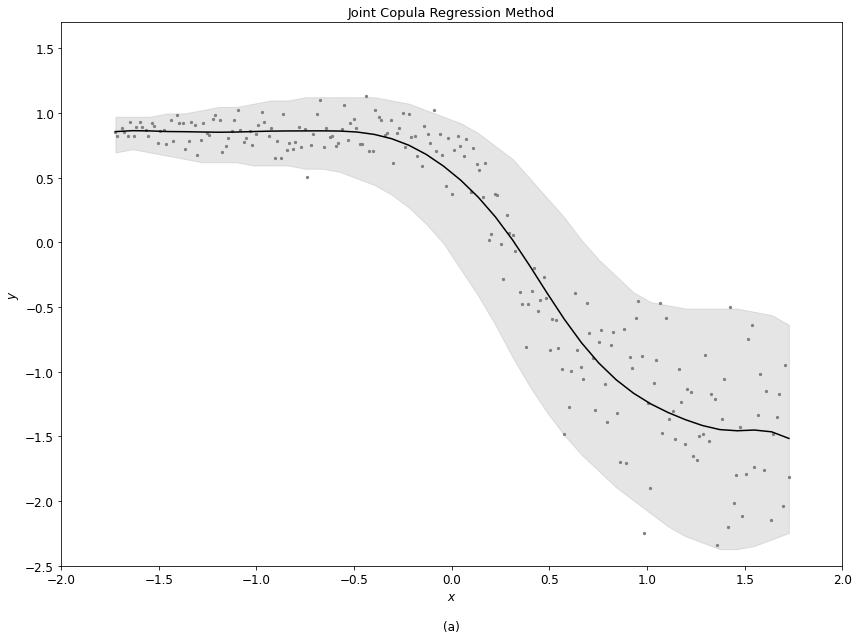

In [19]:
#Load predictive densities
pdf_cop_condj = np.load('jcopula_lidar_pdf_plot.npy')
cdf_cop_condj = np.load('jcopula_lidar_cdf_plot.npy')


#preprocess
cdf_condj_plot = cdf_cop_condj.reshape(n_plot_marg[1],n_plot_marg[0])
pdf_condj_plot = pdf_cop_condj.reshape(n_plot_marg[1],n_plot_marg[0])

n_plot_x = np.shape(x_plot)[0]

bot25_joint = np.zeros(n_plot_x)
top25_joint = np.zeros(n_plot_x)
mean_cop_joint = np.zeros(n_plot_x)

for j in range(n_plot_x):
    bot25_joint[j] =y_plot[np.searchsorted(cdf_condj_plot[:,j],0.025)-1]
    top25_joint[j] =y_plot[np.searchsorted(cdf_condj_plot[:,j],0.975)-1]
    mean_cop_joint[j] = np.sum(pdf_condj_plot[:,j]*y_plot*dy)

    
#plot
f = plt.figure(figsize = (14,10))
#plt.subplot(1,2,1)
plt.plot(x_plot,mean_cop_joint,color = 'k',label = 'Posterior mean')
plt.fill_between(x_plot, bot25_joint, top25_joint, alpha = 0.2, label = '95% predictive interval',color = 'grey')
plt.scatter(x,y,label = 'Data',s = 5,color = 'grey')
plt.xlabel('$x$\n \n(a)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('Joint Copula Regression Method',fontsize = 13)
#plt.legend(loc = 3)

## Conditonal Method

###Helper Functions for $\texttt{fit_copula_cregression}$


In [20]:
@custom_jvp 
def ndtri_(u):
    return ndtri(u)
@ndtri_.defjvp
def f_jvp(primals, tangents):
    u, = primals
    u_dot, = tangents
    primal_out = ndtri_(u)
    tangent_out = (1/norm.pdf(primal_out))*u_dot
    return primal_out, tangent_out
ndtri_ = jit(ndtri_)

#Custom derivatives for logPhi to speed up autograd
@custom_jvp
def norm_logcdf(z):
    return norm.logcdf(z)
@norm_logcdf.defjvp
def f_jvp(primals, tangents):
    z, = primals
    z_dot, = tangents
    primal_out = norm_logcdf(z)
    tangent_out = jnp.exp(norm.logpdf(z)-primal_out)*z_dot
    return primal_out, tangent_out
norm_logcdf = jit(norm_logcdf)


@jit
def norm_copula_logdistribution_logdensity(u,v,rho):
    #clip to prevent 0s and 1s in CDF, needed for numerical stability in high d.
    eps = 1e-6
    u = jnp.clip(u,eps,1-eps) 
    v = jnp.clip(v,eps,1-eps)
    
    #for reverse mode
    pu = ndtri_(u)
    pv = ndtri_(v)
    z = (pu - rho*pv)/jnp.sqrt(1- rho**2)

    logcop_dist = norm_logcdf(z)
    logcop_dist = jnp.clip(logcop_dist,jnp.log(eps),jnp.log(1-eps))
    logcop_dens = -0.5*jnp.log(1-rho**2) + (0.5/(1-rho**2))*(-(rho**2)*(pu**2 + pv**2)+ 2*rho*pu*pv)

    return logcop_dist,logcop_dens

def update_copula_single(logcdf_conditionals,logpdf_joints,u,v,logalpha,rho): 
    d = jnp.shape(logpdf_joints)[0]

    logcop_distribution,logcop_dens = norm_copula_logdistribution_logdensity(u,v,rho)

    #Calculate product copulas
    logcop_dens_prod = jnp.cumsum(logcop_dens)

    #staggered 1 step to calculate conditional cdfs
    logcop_dens_prod_staggered = jnp.concatenate((jnp.zeros(1),logcop_dens_prod[0:d-1]))

    log1alpha = jnp.log1p(-jnp.exp(logalpha))

    logcdf_conditionals = jnp.logaddexp((log1alpha + logcdf_conditionals),(logalpha + logcop_dens_prod_staggered + logcop_distribution))\
                           -jnp.logaddexp(log1alpha,(logalpha+logcop_dens_prod_staggered))

    logpdf_joints = jnp.logaddexp(log1alpha, (logalpha+logcop_dens_prod))+logpdf_joints     

    return logcdf_conditionals,logpdf_joints

update_copula = jit(vmap(update_copula_single,(0,0,0,None,0,None))) 

@jit
def calc_logkxx_single(x,x_new,rho_x):
    logk_xx = -0.5*jnp.sum(jnp.log(1-rho_x**2)) -jnp.sum((0.5/(1-rho_x**2))*(((rho_x**2)*(x**2 + x_new**2) - 2*rho_x*x*x_new)))
    return logk_xx
calc_logkxx = jit(vmap(calc_logkxx_single,(0,None,None)))

@jit
def update_pn(carry,i):
    vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,x,rho,rho_x = carry

    #Compute new x
    x_new = x[i]
    logalpha = jnp.log(2.- (1/(i+1)))-jnp.log(i+2)

    #compute x rhos/alphas
    logk_xx = calc_logkxx(x,x_new,rho_x)
    logalphak_xx = logalpha + logk_xx
    log1alpha = jnp.log1p(-jnp.exp(logalpha))
    logalpha_x = (logalphak_xx) - (jnp.logaddexp(log1alpha,logalphak_xx)) #alpha*k_xx /(1-alpha + alpha*k_xx)

    #clip for numerical stability to prevent NaNs
    eps = 1e-5 #1e-6 causes optimization to fail
    logalpha_x = jnp.clip(logalpha_x,jnp.log(eps),jnp.log(1-eps))

    u = jnp.exp(logcdf_conditionals_yn)
    v = jnp.exp(logcdf_conditionals_yn[i])

    #vn = index_update(vn,i,v) #remember history of vn
    vn = vn.at[i].set(v)
 
    #preq_loglik = index_update(preq_loglik,i,logpdf_joints_yn[i,-1])
    preq_loglik = preq_loglik.at[i].set(logpdf_joints_yn[i,-1])
    
    logcdf_conditionals_yn,logpdf_joints_yn= update_copula(logcdf_conditionals_yn,logpdf_joints_yn,u,v,logalpha_x,rho)
    carry = vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,x,rho,rho_x
    return carry,i
  
#Scan over y_{1:n}
@jit
def update_pn_scan(carry,rng):
    return scan(update_pn,carry,rng)

#Initialize marginal p_0
def init_marginals_single(y_test):
    d = jnp.shape(y_test)[0]

    #initialize
    logcdf_init_marginals = jnp.zeros(d)
    logpdf_init_marginals = jnp.zeros(d)

    logcdf_init_conditionals = jnp.zeros(d)
    logpdf_init_joints = jnp.ones(d)

    ##CONTINUOUS CASE
    #normal(0,1)
    mean0 = 0.
    std0 = 1.

    logcdf_init_marginals = norm.logcdf(y_test,loc = mean0,scale = std0)#marginal initial cdfs
    logpdf_init_marginals= norm.logpdf(y_test,loc = mean0,scale = std0) #marginal initial pdfs

    #clip outliers
    eps = 1e-6
    logcdf_init_marginals = jnp.clip(logcdf_init_marginals,jnp.log(eps),jnp.log(1-eps))
    logpdf_init_marginals =jnp.clip(logpdf_init_marginals, jnp.log(eps),jnp.inf)
    ##
    
    #Joint/conditional from marginals
    logpdf_init_joints= jnp.cumsum(logpdf_init_marginals)
    logcdf_init_conditionals= logcdf_init_marginals

    return  logcdf_init_conditionals,logpdf_init_joints
init_marginals = jit(vmap(init_marginals_single,(0)))

@jit
def update_pn_loop(rho,rho_x,y,x):
    n = jnp.shape(y)[0]
    preq_loglik = jnp.zeros((n,1)) #prequential joint loglik for y | x
    vn = jnp.zeros((n,1)) #conditional cdf history of yn, no need to differentiate wrt

    #initialize cdf/pdf
    init_marginals = jit(vmap(init_marginals_single,(0)))
    logcdf_conditionals_yn, logpdf_joints_yn= init_marginals(y)

    carry = vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,x,rho,rho_x
    rng = jnp.arange(n)
    carry,rng = update_pn_scan(carry,rng)

    vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik,*_ = carry

    return vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik
update_pn_loop_perm = jit(vmap(update_pn_loop,(None,None,0,0)))


In [21]:
@jit
def negpreq_cconditloglik_perm(hyperparam,y_perm,x_perm):
    rho = 1/(1+jnp.exp(hyperparam[0])) #force 0 <rho<1
    rho_x = 1/(1+jnp.exp(hyperparam[1:]))#force 0<rho_x < 1

    n = jnp.shape(y_perm)[1]

    #Compute v_{1:n} and prequential loglik
    vn,logcdf_conditionals_yn,logpdf_joints_yn,preq_loglik = update_pn_loop_perm(rho,rho_x,y_perm,x_perm)

    #Average over permutations
    preq_loglik = jnp.mean(preq_loglik,axis = 0)

    #Sum prequential terms
    preq_jointloglik = jnp.sum(preq_loglik[:,-1]) #only look at joint pdf
    return -preq_jointloglik/n

def fun_ccll_perm_sp(hyperparam,y_perm,x_perm):
    return np.array(negpreq_cconditloglik_perm(hyperparam,y_perm,x_perm))

def grad_ccll_perm_sp(hyperparam,y_perm,x_perm):
  grad_ccll_perm = jit(grad(negpreq_cconditloglik_perm))
  return np.array(grad_ccll_perm(hyperparam,y_perm,x_perm)) 

In [22]:
def fit_copula_cregression(y,x,n_perm = 10, seed = 20,n_perm_optim = None,single_x_bandwidth = True):
    #Set seed for scipy
    np.random.seed(seed)

    #Generate random permutations
    key = PRNGKey(seed)
    key,*subkey = split(key,n_perm +1 )
    subkey = jnp.array(subkey)
    y_perm = vmap(permutation,(0,None))(subkey,y).reshape(n_perm,-1,1)
    x_perm = vmap(permutation,(0,None))(subkey,x)

    #Initialize parameter and put on correct scale to lie in [0,1]
    d = jnp.shape(x)[1]
    if single_x_bandwidth ==True:
        rho_init = 0.8*jnp.ones(2) 
    else: 
        rho_init = 0.8*jnp.ones(d+1)
    hyperparam_init = jnp.log(1/rho_init - 1) 

    #calculate rho_opt
    #either use all permutations or a selected number to fit bandwidth
    if n_perm_optim is None:
        y_perm_opt = y_perm
        x_perm_opt = x_perm
    else:
        y_perm_opt = y_perm[0:n_perm_optim]
        x_perm_opt = x_perm[0:n_perm_optim]

    #Compiling
    print('Compiling...')
    start = time.time()
    temp = fun_ccll_perm_sp(hyperparam_init,y_perm_opt,x_perm_opt)
    temp = grad_ccll_perm_sp(hyperparam_init,y_perm_opt,x_perm_opt)

    update_pn_loop_perm = jit(vmap(update_pn_loop,(None,None,0,0)))
    temp = update_pn_loop_perm(hyperparam_init[0],hyperparam_init[1:],y_perm,x_perm)[0].block_until_ready()
    end = time.time()
    print('Compilation time: {}s'.format(round(end-start, 3)))

    print('Optimizing...')
    start = time.time()
    # Condit preq loglik
    opt = minimize(fun = fun_ccll_perm_sp, x0= hyperparam_init,\
             args = (y_perm_opt,x_perm_opt),jac =grad_ccll_perm_sp,method = 'SLSQP',options={'maxiter':100, 'ftol': 1e-4})
    #check optimization succeeded
    if opt.success == False:
        print('Optimization failed')

    #unscale hyperparameter
    hyperparam_opt = opt.x
    rho_opt = 1/(1+jnp.exp(hyperparam_opt[0]))
    #l_scale_opt = jnp.exp(hyperparam_opt[1:])
    rho_opt_x = 1/(1+jnp.exp(hyperparam_opt[1:]))
    end = time.time()


    print('Optimization time: {}s'.format(round(end-start, 3)))
        
    print('Fitting...')

    start = time.time()
    update_pn_loop_perm = jit(vmap(update_pn_loop,(None,None,0,0)))
    vn_perm= update_pn_loop_perm(rho_opt,rho_opt_x,y_perm,x_perm)[0].block_until_ready()
    end = time.time()
    print('Fit time: {}s'.format(round(end-start, 3)))

    copula_cregression_obj = namedtuple('copula_cregression_obj',['vn_perm','rho_opt','rho_x_opt','preq_loglik','x_perm'])
    return copula_cregression_obj(vn_perm,rho_opt,rho_opt_x,-opt.fun,x_perm)


In [23]:
### CONDITIONAL COPULA METHOD ###
print('Method: Conditional Copula')

copula_cregression_obj = fit_copula_cregression(jnp.array(y),jnp.array(x),single_x_bandwidth = False,n_perm_optim = 10)
print(copula_cregression_obj.rho_opt)
print(copula_cregression_obj.rho_x_opt)
print(copula_cregression_obj.preq_loglik)



Method: Conditional Copula
Compiling...
Compilation time: 12.127s
Optimizing...
Optimization time: 63.716s
Fitting...
Fit time: 1.603s
0.8172979
[0.9390087]
-0.0006451499


###Helper Functions for $\texttt{predict_copula_cregression}$


In [24]:
@jit
def norm_copula_logdistribution_logdensity(u,v,rho):
    #clip to prevent 0s and 1s in CDF, needed for numerical stability in high d.
    eps = 1e-6
    u = jnp.clip(u,eps,1-eps) 
    v = jnp.clip(v,eps,1-eps)
    
    #for reverse mode
    pu = ndtri_(u)
    pv = ndtri_(v)
    z = (pu - rho*pv)/jnp.sqrt(1- rho**2)

    logcop_dist = norm_logcdf(z)
    logcop_dist = jnp.clip(logcop_dist,jnp.log(eps),jnp.log(1-eps))
    logcop_dens = -0.5*jnp.log(1-rho**2) + (0.5/(1-rho**2))*(-(rho**2)*(pu**2 + pv**2)+ 2*rho*pu*pv)

    return logcop_dist,logcop_dens

#Compute copula update for a single data point
def update_copula_single(logcdf_conditionals,logpdf_joints,u,v,logalpha,rho): 
    d = jnp.shape(logpdf_joints)[0]

    logcop_distribution,logcop_dens = norm_copula_logdistribution_logdensity(u,v,rho)

    #Calculate product copulas
    logcop_dens_prod = jnp.cumsum(logcop_dens)

    #staggered 1 step to calculate conditional cdfs
    logcop_dens_prod_staggered = jnp.concatenate((jnp.zeros(1),logcop_dens_prod[0:d-1]))

    log1alpha = jnp.log1p(-jnp.exp(logalpha))

    logcdf_conditionals = jnp.logaddexp((log1alpha + logcdf_conditionals),(logalpha + logcop_dens_prod_staggered + logcop_distribution))\
                           -jnp.logaddexp(log1alpha,(logalpha+logcop_dens_prod_staggered))

    logpdf_joints = jnp.logaddexp(log1alpha, (logalpha+logcop_dens_prod))+logpdf_joints     

    return logcdf_conditionals,logpdf_joints

@jit
def update_ptest_single(carry,i):
    vn,logcdf_conditionals_ytest,logpdf_joints_ytest,x,x_test,rho,rho_x = carry

    x_new = x[i]
    logalpha = jnp.log(2.- (1/(i+1)))-jnp.log(i+2)

    #compute x rhos/alphas
    logk_xx = calc_logkxx_single(x_test,x_new,rho_x)
    
    logalphak_xx = logalpha + logk_xx
    log1alpha = jnp.log1p(-jnp.exp(logalpha))
    logalpha_x = (logalphak_xx) - (jnp.logaddexp(log1alpha,logalphak_xx))

    #clip for numerical stability to prevent NaNs
    eps = 1e-5 #1e-6 causes optimization to fail
    logalpha_x = jnp.clip(logalpha_x,jnp.log(eps),jnp.log(1-eps))

    u = jnp.exp(logcdf_conditionals_ytest)
    v = vn[i]

    logcdf_conditionals_ytest,logpdf_joints_ytest= update_copula_single(logcdf_conditionals_ytest,logpdf_joints_ytest,u,v,logalpha_x,rho)

    carry = vn,logcdf_conditionals_ytest,logpdf_joints_ytest,x,x_test,rho,rho_x
    return carry,i

#Scan over n observed data
@jit
def update_ptest_single_scan(carry,rng):
    return scan(update_ptest_single,carry,rng)

@jit
def update_ptest_single_loop(vn,rho,rho_x,x,y_test,x_test):
    n = jnp.shape(vn)[0]

    logcdf_conditionals_ytest, logpdf_joints_ytest= init_marginals_single(y_test)

    carry = vn,logcdf_conditionals_ytest,logpdf_joints_ytest,x,x_test,rho,rho_x
    rng = jnp.arange(n)
    carry,rng = update_ptest_single_scan(carry,rng)
    vn,logcdf_conditionals_ytest,logpdf_joints_ytest,x,x_test,rho,rho_x = carry

    return logcdf_conditionals_ytest,logpdf_joints_ytest

update_ptest_single_loop_perm = jit(vmap(update_ptest_single_loop,(0,None,None,0,None,None))) #vmap over vn_perm

@jit
def update_ptest_single_loop_perm_av(vn_perm,rho,rho_x,x_perm,y_test,x_test):
    n_perm = jnp.shape(vn_perm)[0]
    logcdf_conditionals, logpdf_joints = update_ptest_single_loop_perm(vn_perm,rho,rho_x,x_perm,y_test,x_test)
    logcdf_conditionals = logsumexp(logcdf_conditionals,axis = 0) - jnp.log(n_perm)
    logpdf_joints = logsumexp(logpdf_joints,axis = 0) - jnp.log(n_perm)
    return logcdf_conditionals,logpdf_joints

#Vmap over multiple test points
update_ptest_loop_perm_av = jit(vmap(update_ptest_single_loop_perm_av,(None,None,None,None,0,0)))

In [25]:
def predict_copula_cregression(copula_cregression_obj,y_test,x_test):
    #code loop for now, can speed up to use indices
    n_perm = np.shape(copula_cregression_obj.x_perm)[0]
    n = np.shape(copula_cregression_obj.x_perm)[1]
    n_test = np.shape(x_test)[0]
    logk_xx = np.zeros((n_perm,n,n_test))

    print('Predicting...')
    start = time.time()
    logcdf_conditionals,logpdf_joints = update_ptest_loop_perm_av(copula_cregression_obj.vn_perm,copula_cregression_obj.rho_opt\
                                                                         ,copula_cregression_obj.rho_x_opt,copula_cregression_obj.x_perm, y_test.reshape(-1,1),x_test)
    logcdf_conditionals = logcdf_conditionals.block_until_ready() #for accurate timing
    end = time.time()
    print('Prediction time: {}s'.format(round(end-start, 3)))
    return logcdf_conditionals,logpdf_joints
### ###


In [26]:
logcdf_conditionals,logpdf_joints = predict_copula_cregression(copula_cregression_obj,y_plot_ravel,x_plot_ravel)


## Compute predictive means and quantiles
pdf_cop_condc = jnp.exp(logpdf_joints)
cdf_cop_condc = jnp.exp(logcdf_conditionals)
cdf_condc_plot = cdf_cop_condc.reshape(n_plot_marg[1],n_plot_marg[0])
pdf_condc_plot = pdf_cop_condc.reshape(n_plot_marg[1],n_plot_marg[0])

n_plot_x = np.shape(x_plot)[0]

jnp.save('ccopula_lidar_pdf_plot',pdf_condc_plot)
jnp.save('ccopula_lidar_cdf_plot',cdf_condc_plot)


Predicting...
Prediction time: 7.596s


Text(0.5, 1.0, 'Conditional Copula Regression Method')

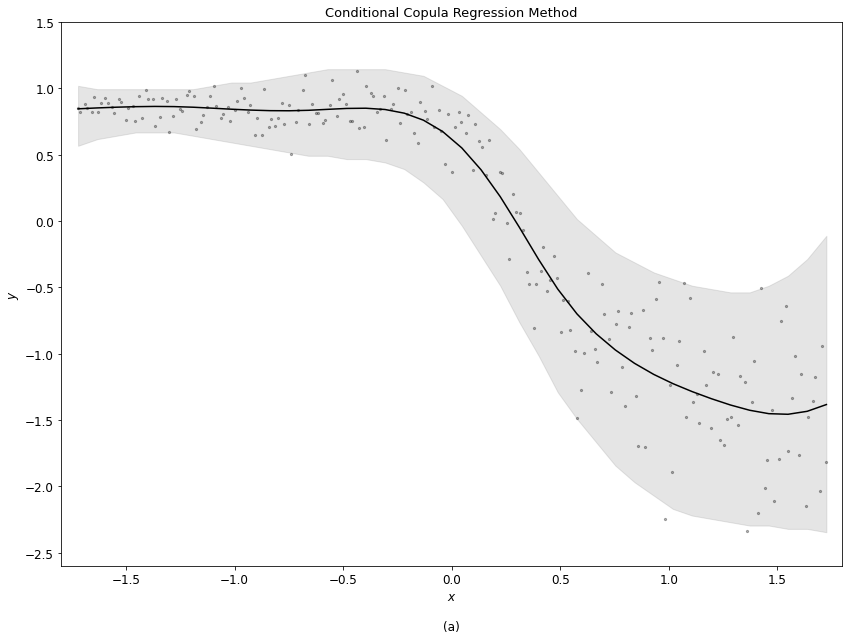

In [27]:
pdf_cop_condc = np.load('ccopula_lidar_pdf_plot.npy')
cdf_cop_condc = np.load('ccopula_lidar_cdf_plot.npy')

cdf_condc_plot = cdf_cop_condc.reshape(n_plot_marg[1],n_plot_marg[0])
pdf_condc_plot = pdf_cop_condc.reshape(n_plot_marg[1],n_plot_marg[0])

n_plot_x = np.shape(x_plot)[0]

bot25_cond = np.zeros(n_plot_x)
top25_cond = np.zeros(n_plot_x)
mean_cop_cond = np.zeros(n_plot_x)

for j in range(n_plot_x):
    bot25_cond[j] =y_plot[np.searchsorted(cdf_condc_plot[:,j],0.025)-1]
    top25_cond[j] =y_plot[np.searchsorted(cdf_condc_plot[:,j],0.975)-1]
    mean_cop_cond[j] = np.sum(pdf_condc_plot[:,j]*y_plot*dy)

xlim = (-1.8,1.8)
ylim = (-2.6,1.5)
    
#plot
f = plt.figure(figsize = (14,10))
plt.plot(x_plot,mean_cop_cond,color = 'k',label = 'Mean')
plt.fill_between(x_plot, bot25_cond, top25_cond, alpha = 0.2, label = '95% predictive interval',color = 'grey')
plt.scatter(x,y,label = 'Data',s = 5,color = 'k',alpha = 0.3)
plt.xlabel('$x$\n \n(a)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('Conditional Copula Regression Method',fontsize = 13)


## GP

In [28]:
#Gaussian Process
print('Method: GP')
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
kernel =ConstantKernel()*RBF() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10,normalize_y = True)
gp.fit(x, y)
mean_gp,std_gp = gp.predict(x_plot.reshape(-1,1),return_std = True) 
jnp.save('gp_lidar_mean',mean_gp)
jnp.save('gp_lidar_std',std_gp)

Method: GP


(-1.8, 1.8)

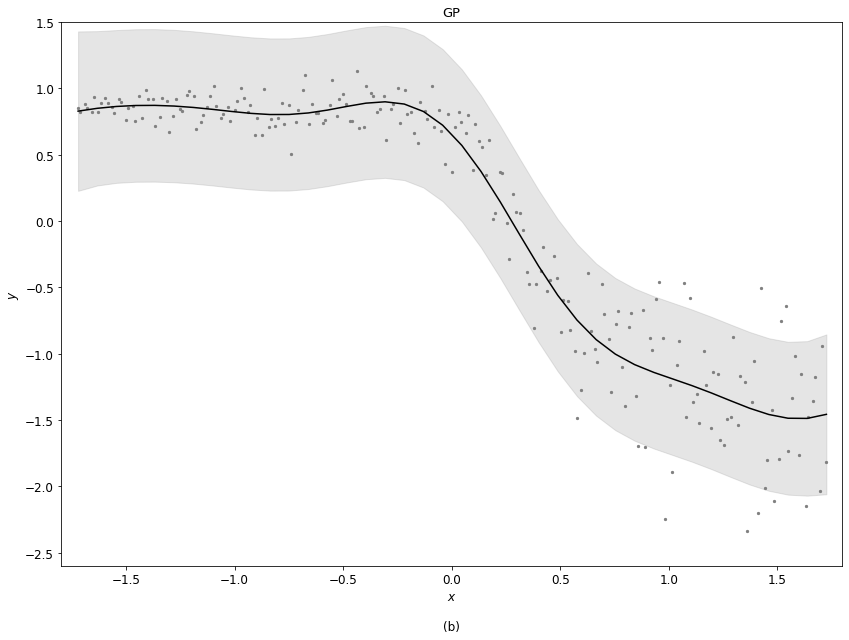

In [29]:
mean_gp = np.load('gp_lidar_mean.npy')
std_gp = np.load('gp_lidar_std.npy')

f = plt.figure(figsize = (14,10))

plt.title('GP',fontsize = 13)
plt.plot(x_plot,mean_gp,label = 'Predictive mean',color = 'k')
plt.fill_between(x_plot, mean_gp + 2*std_gp, mean_gp - 2*std_gp, alpha = 0.2, label = '95% predictive interval',color = 'grey')
plt.scatter(x,y,label = 'Data',s = 5,color = 'grey')
plt.xlabel('$x$\n \n(b)',fontsize = 12)
plt.ylabel('$y$',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
#plt.legend(loc = 3)
plt.ylim(ylim)
plt.xlim(xlim)